# Step 1 - Brief description of the problem and data

In this project, I will be creating an algorithm to identify metastatic cancer in small image patches taken from larger digital pathology scans as described on the [Histopathologic Cancer Detection Kaggle project page](https://www.kaggle.com/c/histopathologic-cancer-detection/overview).

The data includes 220,025 image files named with an image `id` and a `.tif` suffix.  These image files are 96x96 pixels with an RGB color space.

It also includes a file named `train_labels.csv` with 2 columns;
1. `id`: The same id used for the image file name.  For example, the training file `0a0a2e923bdedb11f270dcd3f11d0f001df98f00.tif` corresponds to the row in the CSV file with that same number in the `id` column.
2. `label`: 0 = does not contain metastatic cancer tissue.  1 = contains metastatic cancer tissue.

# Part 2 - Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data

Show a few visualizations like histograms. Describe any data cleaning procedures. Based on your EDA, what is your plan of analysis?

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import LearningRateScheduler

# Load training data
train_dir = 'train'
train_labels_file = 'train_labels.csv'
img_size = (96, 96)

# Load labels
train_labels_df = pd.read_csv(train_labels_file)
train_labels_df['filename'] = train_labels_df['id'].astype(str) + '.tif'
train_labels_df['label'] = train_labels_df['label'].astype(str)  # Convert labels to string for the generator

# Check for missing values.  If any are found, consider deleting them to clean up the data.
train_labels_df.isnull().sum()

id          0
label       0
filename    0
dtype: int64

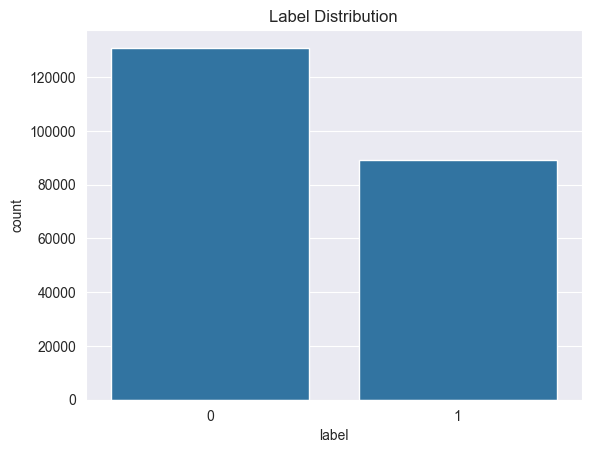

In [2]:
# Look at the distribution of the labels.  An even distribution would be best for training.  However, an imbalance is expected with many 0's and few 1's because most of the population does not have cancer.
sns.countplot(x='label', data=train_labels_df)
plt.title('Label Distribution')
plt.show()


# Part 3 - Model Architecture

Various types of convolutional neural networks (CNNs) can be used to solve this issue.  Since the dataset for this project contains many gigabytes of information, it is important to choose a model that can be trained efficiently so that I am able to test it on my personal PC.  Ideally the model would take less than a minute to train so that I can perform hyperparameter tuning with various options without spending excessive time.

In [3]:
# Image data generator for training
train_datagen = ImageDataGenerator(rescale=1.0/255.0, validation_split=0.2)

train_generator = train_datagen.flow_from_dataframe(
    train_labels_df,
    directory=train_dir,
    x_col='filename',
    y_col='label',
    target_size=img_size,
    batch_size=32,
    class_mode='binary',
    subset='training'
)

validation_generator = train_datagen.flow_from_dataframe(
    train_labels_df,
    directory=train_dir,
    x_col='filename',
    y_col='label',
    target_size=img_size,
    batch_size=32,
    class_mode='binary',
    subset='validation'
)

# Define CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_size[0], img_size[1], 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary classification
])

# Compile model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.


/Users/asnyder/PycharmProjects/deep-learning-week3-cancer-detection/.venv1/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-11-17 19:26:19.407632: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2024-11-17 19:26:19.407665: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-11-17 19:26:19.407670: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-11-17 19:26:19.407697: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-11-17 19:26:19.407711: I tensorflow/core/common_run

In [4]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


Num GPUs Available:  1


In [3]:
# Train model
epochs = 5
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator
)

Epoch 1/5


/Users/asnyder/PycharmProjects/deep-learning-week3-cancer-detection/.venv1/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2024-11-15 15:13:32.403081: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


5501/5501 ━━━━━━━━━━━━━━━━━━━━ 159s 29ms/step - accuracy: 0.7808 - loss: 0.4728 - val_accuracy: 0.8518 - val_loss: 0.3568
Epoch 2/5
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 158s 29ms/step - accuracy: 0.8546 - loss: 0.3438 - val_accuracy: 0.8824 - val_loss: 0.2869
Epoch 3/5
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 157s 28ms/step - accuracy: 0.8773 - loss: 0.2962 - val_accuracy: 0.8770 - val_loss: 0.2899
Epoch 4/5
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 158s 29ms/step - accuracy: 0.8920 - loss: 0.2660 - val_accuracy: 0.8939 - val_loss: 0.2606
Epoch 5/5
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 157s 29ms/step - accuracy: 0.8992 - loss: 0.2513 - val_accuracy: 0.8987 - val_loss: 0.2551


In [5]:
def load_test_data_and_predict(model, output_file_name):
    test_dir = 'test'
    test_images = [f for f in os.listdir(test_dir) if f.endswith('.tif')]
    predictions = []

    for img_file in test_images:
        img_path = os.path.join(test_dir, img_file)
        img = image.load_img(img_path, target_size=img_size)
        img_array = image.img_to_array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)

        prediction = model.predict(img_array)
        label = 1 if prediction[0][0] >= 0.5 else 0
        predictions.append((img_file.replace('.tif', ''), label))

    # Save predictions to CSV
    submission_df = pd.DataFrame(predictions, columns=['id', 'label'])
    submission_df.to_csv(output_file_name, index=False)

    print("Training complete. Predictions saved to submission.csv.")

In [ ]:
load_test_data_and_predict(model, 'submission.csv')

# Part 4 - Results and Analysis

Run hyperparameter tuning, try different architectures for comparison, apply techniques to improve training or performance, and discuss what helped.

Includes results with tables and figures. There is an analysis of why or why not something worked well, troubleshooting, and a hyperparameter optimization procedure summary.

In [6]:
# Take model1, add 2 dropout layers
model2 = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(96, 96, 3)),
    MaxPooling2D(2,2),
    Dropout(0.2), # New in model 2
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Dropout(0.2), # New in model 2
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(256, activation='relu'), # This was 128 in prev model
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile model
model2.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

/Users/asnyder/PycharmProjects/deep-learning-week3-cancer-detection/.venv1/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [25]:
epochs = 5
history = model2.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator
)

Epoch 1/5


/Users/asnyder/PycharmProjects/deep-learning-week3-cancer-detection/.venv1/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2024-11-17 13:15:00.565731: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


5501/5501 ━━━━━━━━━━━━━━━━━━━━ 195s 35ms/step - accuracy: 0.7781 - loss: 0.4764 - val_accuracy: 0.8253 - val_loss: 0.3914
Epoch 2/5
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 225s 41ms/step - accuracy: 0.8511 - loss: 0.3485 - val_accuracy: 0.8659 - val_loss: 0.3175
Epoch 3/5
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 226s 41ms/step - accuracy: 0.8672 - loss: 0.3169 - val_accuracy: 0.8844 - val_loss: 0.2810
Epoch 4/5
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 220s 40ms/step - accuracy: 0.8791 - loss: 0.2901 - val_accuracy: 0.8662 - val_loss: 0.3160
Epoch 5/5
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 210s 38ms/step - accuracy: 0.8880 - loss: 0.2756 - val_accuracy: 0.9005 - val_loss: 0.2530


In [ ]:
load_test_data_and_predict(model2, 'submission_extra_dropout_layers.csv')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

In [8]:
def lr_schedule(epoch, lr):
    if epoch > 2:
        return lr * 0.5
    return lr

callbacks = [LearningRateScheduler(lr_schedule)]

history = model2.fit(
    train_generator,
    epochs=5,
    validation_data=validation_generator,
    callbacks=callbacks
)

Epoch 1/5


/Users/asnyder/PycharmProjects/deep-learning-week3-cancer-detection/.venv1/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2024-11-17 13:58:01.857246: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


5501/5501 ━━━━━━━━━━━━━━━━━━━━ 187s 34ms/step - accuracy: 0.7531 - loss: 0.5120 - val_accuracy: 0.8034 - val_loss: 0.4301 - learning_rate: 0.0010
Epoch 2/5
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 240s 44ms/step - accuracy: 0.8495 - loss: 0.3558 - val_accuracy: 0.8669 - val_loss: 0.3108 - learning_rate: 0.0010
Epoch 3/5
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 216s 39ms/step - accuracy: 0.8715 - loss: 0.3100 - val_accuracy: 0.8817 - val_loss: 0.2794 - learning_rate: 0.0010
Epoch 4/5
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 211s 38ms/step - accuracy: 0.8917 - loss: 0.2667 - val_accuracy: 0.9065 - val_loss: 0.2448 - learning_rate: 5.0000e-04
Epoch 5/5
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 210s 38ms/step - accuracy: 0.9014 - loss: 0.2433 - val_accuracy: 0.9057 - val_loss: 0.2353 - learning_rate: 2.5000e-04


In [ ]:
load_test_data_and_predict(model2, 'submission_lr_schedule.csv')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


In [5]:
model3 = Sequential([
    Conv2D(64, (3, 3), activation='relu', input_shape=(96, 96, 3)), # model 1 uses 32, 64, 128
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(256, activation='relu'), # model 1 uses 128
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile model
model3.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

/Users/asnyder/PycharmProjects/deep-learning-week3-cancer-detection/.venv1/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [6]:
epochs = 5
history = model3.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator
)

Epoch 1/5


/Users/asnyder/PycharmProjects/deep-learning-week3-cancer-detection/.venv1/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2024-11-17 14:39:13.898346: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


5501/5501 ━━━━━━━━━━━━━━━━━━━━ 378s 68ms/step - accuracy: 0.7827 - loss: 0.4723 - val_accuracy: 0.8574 - val_loss: 0.3398
Epoch 2/5
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 1333s 242ms/step - accuracy: 0.8613 - loss: 0.3280 - val_accuracy: 0.8823 - val_loss: 0.2818
Epoch 3/5
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 5665s 1s/step - accuracy: 0.8852 - loss: 0.2813 - val_accuracy: 0.8962 - val_loss: 0.2564
Epoch 4/5
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 4338s 789ms/step - accuracy: 0.8950 - loss: 0.2589 - val_accuracy: 0.8904 - val_loss: 0.2677
Epoch 5/5
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 2293s 417ms/step - accuracy: 0.9035 - loss: 0.2411 - val_accuracy: 0.9021 - val_loss: 0.2464


NameError: name 'load_test_data_and_predict' is not defined

In [ ]:
load_test_data_and_predict(model3, 'submission3.csv')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

In [6]:
model4 = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(96, 96, 3)),
    MaxPooling2D(2,2),
    Dropout(0.2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Dropout(0.2),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile model
model4.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

/Users/asnyder/PycharmProjects/deep-learning-week3-cancer-detection/.venv1/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [7]:
epochs = 5
history = model4.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator
)

Epoch 1/5


/Users/asnyder/PycharmProjects/deep-learning-week3-cancer-detection/.venv1/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2024-11-17 19:27:04.323231: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


5501/5501 ━━━━━━━━━━━━━━━━━━━━ 185s 34ms/step - accuracy: 0.7697 - loss: 0.4870 - val_accuracy: 0.7736 - val_loss: 0.4784
Epoch 2/5
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 204s 37ms/step - accuracy: 0.8299 - loss: 0.3896 - val_accuracy: 0.8060 - val_loss: 0.4237
Epoch 3/5
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 209s 38ms/step - accuracy: 0.8577 - loss: 0.3350 - val_accuracy: 0.8479 - val_loss: 0.3550
Epoch 4/5
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 209s 38ms/step - accuracy: 0.8737 - loss: 0.2994 - val_accuracy: 0.8199 - val_loss: 0.4094
Epoch 5/5
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 215s 39ms/step - accuracy: 0.8862 - loss: 0.2764 - val_accuracy: 0.8701 - val_loss: 0.3115


In [ ]:
load_test_data_and_predict(model4, 'submission_smaller_lr.csv')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


# Step 5 - Conclusion

Discuss and interpret results as well as learnings and takeaways. What did and did not help improve the performance of your models? What improvements could you try in the future?